In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import os, sys, pathlib, random, time, pickle, copy, json
from tqdm import tqdm

In [2]:
device = torch.device("cuda:0")
# device = torch.device("cpu")

In [3]:
# SEED = 147
# SEED = 258
SEED = 369

torch.manual_seed(SEED)
np.random.seed(SEED)

In [4]:
import torch.optim as optim
from torch.utils import data

In [5]:
cifar_train = transforms.Compose([
    transforms.RandomCrop(size=32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465], # mean=[0.5071, 0.4865, 0.4409] for cifar100
        std=[0.2023, 0.1994, 0.2010], # std=[0.2009, 0.1984, 0.2023] for cifar100
    ),
])

cifar_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465], # mean=[0.5071, 0.4865, 0.4409] for cifar100
        std=[0.2023, 0.1994, 0.2010], # std=[0.2009, 0.1984, 0.2023] for cifar100
    ),
])

train_dataset = datasets.CIFAR10(root="../../../../../_Datasets/cifar10/", train=True, download=True, transform=cifar_train)
test_dataset = datasets.CIFAR10(root="../../../../../_Datasets/cifar10/", train=False, download=True, transform=cifar_test)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [7]:
## demo of train loader
xx, yy = iter(train_loader).next()
xx.shape

torch.Size([32, 3, 32, 32])

# Model

In [8]:
class MlpBLock(nn.Module):
    
    def __init__(self, input_dim, hidden_layers_ratio=[2], actf=nn.GELU):
        super().__init__()
        self.input_dim = input_dim
        #### convert hidden layers ratio to list if integer is inputted
        if isinstance(hidden_layers_ratio, int):
            hidden_layers_ratio = [hidden_layers_ratio]
            
        self.hlr = [1]+hidden_layers_ratio+[1]
        
        self.mlp = []
        ### for 1 hidden layer, we iterate 2 times
        for h in range(len(self.hlr)-1):
            i, o = int(self.hlr[h]*self.input_dim),\
                    int(self.hlr[h+1]*self.input_dim)
            self.mlp.append(nn.Linear(i, o))
            self.mlp.append(actf())
        self.mlp = self.mlp[:-1]
        
        self.mlp = nn.Sequential(*self.mlp)
        
    def forward(self, x):
        return self.mlp(x)

In [9]:
MlpBLock(2, [3,4])

MlpBLock(
  (mlp): Sequential(
    (0): Linear(in_features=2, out_features=6, bias=True)
    (1): GELU()
    (2): Linear(in_features=6, out_features=8, bias=True)
    (3): GELU()
    (4): Linear(in_features=8, out_features=2, bias=True)
  )
)

## MLP-Mixer 

In [10]:
class MixerBlock(nn.Module):
    
    def __init__(self, patch_dim, channel_dim):
        super().__init__()
        
        self.ln0 = nn.LayerNorm(channel_dim)
        self.mlp_patch = MlpBLock(patch_dim, [2])
        self.ln1 = nn.LayerNorm(channel_dim)
        self.mlp_channel = MlpBLock(channel_dim, [2])
    
    def forward(self, x):
        ## x has shape-> N, nP, nC/hidden_dims; C=Channel, P=Patch
        
        ######## !!!! Can use same mixer on shape of -> N, C, P;
        
        #### mix per patch
        y = self.ln0(x) ### per channel layer normalization ?? 
        y = torch.swapaxes(y, -1, -2)
        y = self.mlp_patch(y)
        y = torch.swapaxes(y, -1, -2)
        x = x+y
        
        #### mix per channel 
        y = self.ln1(x)
        y = self.mlp_channel(y)
        x = x+y
        return x

In [11]:
class MlpMixer(nn.Module):
    
    def __init__(self, image_dim:tuple, patch_size:tuple, hidden_expansion:float, num_blocks:int, num_classes:int):
        super().__init__()
        
        self.img_dim = image_dim ### must contain (C, H, W) or (H, W)
        
        ### find patch dim
        d0 = int(image_dim[-2]/patch_size[0])
        d1 = int(image_dim[-1]/patch_size[1])
        assert d0*patch_size[0]==image_dim[-2], "Image must be divisible into patch size"
        assert d1*patch_size[1]==image_dim[-1], "Image must be divisible into patch size"
#         self.d0, self.d1 = d0, d1 ### number of patches in each axis
        __patch_size = patch_size[0]*patch_size[1]*image_dim[0] ## number of channels in each patch
    
        ### find channel dim
        channel_size = d0*d1 ## number of patches
        
        ### after the number of channels are changed
        init_dim = __patch_size
        final_dim = int(patch_size[0]*patch_size[1]*hidden_expansion)
        self.unfold = nn.Unfold(kernel_size=patch_size, stride=patch_size)
        #### rescale the patches (patch wise image non preserving transform, unlike bilinear interpolation)
        self.channel_change = nn.Linear(init_dim, final_dim)
        print(f"MLP Mixer : Channes per patch -> Initial:{init_dim} Final:{final_dim}")
        
        
        self.channel_dim = final_dim
        self.patch_dim = channel_size
        
        self.mixer_blocks = []
        for i in range(num_blocks):
            self.mixer_blocks.append(MixerBlock(self.patch_dim, self.channel_dim))
        self.mixer_blocks = nn.Sequential(*self.mixer_blocks)
        
        self.linear = nn.Linear(self.patch_dim*self.channel_dim, num_classes)
        
        
    def forward(self, x):
        bs = x.shape[0]
        x = self.unfold(x).swapaxes(-1, -2)
        x = self.channel_change(x)
        x = self.mixer_blocks(x)
        x = self.linear(x.view(bs, -1))
        return x

In [12]:
mixer = MlpMixer((1, 28, 28), (4, 4), hidden_expansion=2, num_blocks=1, num_classes=10)
mixer

MLP Mixer : Channes per patch -> Initial:16 Final:32


MlpMixer(
  (unfold): Unfold(kernel_size=(4, 4), dilation=1, padding=0, stride=(4, 4))
  (channel_change): Linear(in_features=16, out_features=32, bias=True)
  (mixer_blocks): Sequential(
    (0): MixerBlock(
      (ln0): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (mlp_patch): MlpBLock(
        (mlp): Sequential(
          (0): Linear(in_features=49, out_features=98, bias=True)
          (1): GELU()
          (2): Linear(in_features=98, out_features=49, bias=True)
        )
      )
      (ln1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (mlp_channel): MlpBLock(
        (mlp): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
          (1): GELU()
          (2): Linear(in_features=64, out_features=32, bias=True)
        )
      )
    )
  )
  (linear): Linear(in_features=1568, out_features=10, bias=True)
)

In [13]:
# mixer(torch.randn(3, 1, 28, 28))

## Patch Mixer

In [14]:
class PatchMixerBlock(nn.Module):
    
    def __init__(self, patch_size, num_channel):
        super().__init__()
        self.patch_size = patch_size
        
#         self.unfold = nn.Unfold(kernel_size=patch_size, stride=patch_size)
        ps = None
        if isinstance(patch_size, int):
            ps = patch_size**2
        else:
            ps = patch_size[0]*patch_size[1]
        ps = ps*num_channel
        
        self.ln0 = nn.LayerNorm(ps)
        self.mlp_patch = MlpBLock(ps, [2])
        
#         self.fold = nn.Fold(kernel_size=patch_size, stride=patch_size)
    
    def forward(self, x):
        ## x has shape-> N, C, H, W; C=Channel
        
        sz = x.shape
        
        y = nn.functional.unfold(x, 
                                 kernel_size=self.patch_size, 
                                 stride=self.patch_size
                                )
        #### mix per patch
        y = torch.swapaxes(y, -1, -2)
        y = self.ln0(y) 
        y = self.mlp_patch(y)
        y = torch.swapaxes(y, -1, -2)
        
        y = nn.functional.fold(y, (sz[-2], sz[-1]), 
                               kernel_size=self.patch_size, 
                               stride=self.patch_size
                              )
        x = x+y
        return x

In [15]:
pmb = PatchMixerBlock(8, 3)
pmb

PatchMixerBlock(
  (ln0): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
  (mlp_patch): MlpBLock(
    (mlp): Sequential(
      (0): Linear(in_features=192, out_features=384, bias=True)
      (1): GELU()
      (2): Linear(in_features=384, out_features=192, bias=True)
    )
  )
)

In [16]:
# pmb(torch.randn(1, 3, 35, 35)).shape

In [17]:
def get_factors(n):
    facts = []
    for i in range(2, n+1):
        if n%i == 0:
            facts.append(i)
    return facts

class PatchMlpMixer(nn.Module):
    
    def __init__(self, image_dim:tuple, patch_sizes:tuple, input_scale:float, num_blocks:int, num_classes:int):
        super().__init__()
        
        self.img_dim = image_dim ### must contain (C, H, W)
        
        scaled_img_size = int(image_dim[-2]*input_scale), int(image_dim[-1]*input_scale)
        if input_scale==1:
            self.scaler = lambda x: x
        else:
            self.scaler = nn.UpsamplingBilinear2d(size=scaled_img_size)
        
        print(f"Scaled Image Size: {scaled_img_size}")
        print(f"Prime factors of image size")
        print(f"H -> {get_factors(scaled_img_size[0])}")
        print(f"W -> {get_factors(scaled_img_size[1])}")
        
        ### find number of channel for input, the channel is 
        num_channel = image_dim[0]
        
        self.mixer_blocks = []
        for i in range(num_blocks):
            for ps in patch_sizes:
                self.mixer_blocks.append(PatchMixerBlock(ps, num_channel))
                
        self.mixer_blocks = nn.Sequential(*self.mixer_blocks)
        self.linear = nn.Linear(scaled_img_size[0]*scaled_img_size[1]*num_channel, num_classes)
    
    def forward(self, x):
        bs = x.shape[0]
        x = self.scaler(x)
        x = self.mixer_blocks(x)
        x = self.linear(x.view(bs, -1))
        return x

In [18]:
patch_mixer = PatchMlpMixer((1, 32, 32), patch_sizes=[5, 7], input_scale=1.1, num_blocks=5, num_classes=10)

Scaled Image Size: (35, 35)
Prime factors of image size
H -> [5, 7, 35]
W -> [5, 7, 35]


In [19]:
# patch_mixer(torch.randn(3, 1, 32, 32)).shape

In [20]:
patch_mixer

PatchMlpMixer(
  (scaler): UpsamplingBilinear2d(size=(35, 35), mode=bilinear)
  (mixer_blocks): Sequential(
    (0): PatchMixerBlock(
      (ln0): LayerNorm((25,), eps=1e-05, elementwise_affine=True)
      (mlp_patch): MlpBLock(
        (mlp): Sequential(
          (0): Linear(in_features=25, out_features=50, bias=True)
          (1): GELU()
          (2): Linear(in_features=50, out_features=25, bias=True)
        )
      )
    )
    (1): PatchMixerBlock(
      (ln0): LayerNorm((49,), eps=1e-05, elementwise_affine=True)
      (mlp_patch): MlpBLock(
        (mlp): Sequential(
          (0): Linear(in_features=49, out_features=98, bias=True)
          (1): GELU()
          (2): Linear(in_features=98, out_features=49, bias=True)
        )
      )
    )
    (2): PatchMixerBlock(
      (ln0): LayerNorm((25,), eps=1e-05, elementwise_affine=True)
      (mlp_patch): MlpBLock(
        (mlp): Sequential(
          (0): Linear(in_features=25, out_features=50, bias=True)
          (1): GELU()
    

#### Final Model

In [21]:
# # model = MlpMixer((3, 32, 32), (8, 8), hidden_expansion=2.525, num_blocks=5, num_classes=10)
# model = MlpMixer((3, 32, 32), (4, 4), hidden_expansion=9.2, num_blocks=10, num_classes=10)
# model = model.to(device)

In [22]:
model = PatchMlpMixer((3, 32, 32), patch_sizes=[5, 7], input_scale=1.1, num_blocks=10, num_classes=10)
model = model.to(device)

Scaled Image Size: (35, 35)
Prime factors of image size
H -> [5, 7, 35]
W -> [5, 7, 35]


In [23]:
model

PatchMlpMixer(
  (scaler): UpsamplingBilinear2d(size=(35, 35), mode=bilinear)
  (mixer_blocks): Sequential(
    (0): PatchMixerBlock(
      (ln0): LayerNorm((75,), eps=1e-05, elementwise_affine=True)
      (mlp_patch): MlpBLock(
        (mlp): Sequential(
          (0): Linear(in_features=75, out_features=150, bias=True)
          (1): GELU()
          (2): Linear(in_features=150, out_features=75, bias=True)
        )
      )
    )
    (1): PatchMixerBlock(
      (ln0): LayerNorm((147,), eps=1e-05, elementwise_affine=True)
      (mlp_patch): MlpBLock(
        (mlp): Sequential(
          (0): Linear(in_features=147, out_features=294, bias=True)
          (1): GELU()
          (2): Linear(in_features=294, out_features=147, bias=True)
        )
      )
    )
    (2): PatchMixerBlock(
      (ln0): LayerNorm((75,), eps=1e-05, elementwise_affine=True)
      (mlp_patch): MlpBLock(
        (mlp): Sequential(
          (0): Linear(in_features=75, out_features=150, bias=True)
          (1): GEL

In [24]:
print("number of params: ", sum(p.numel() for p in model.parameters())) 
## Patch ||  1137220
## Mixer ||  1141703

number of params:  1137220


## Training

In [25]:
# model_name = f'mlp_mixer_c10_s{SEED}'
model_name = f'patch_mixer_c10_s{SEED}'

In [26]:
EPOCHS = 200
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [27]:
STAT ={'train_stat':[], 'test_stat':[]}

In [28]:
## Following is copied from 
### https://github.com/kuangliu/pytorch-cifar/blob/master/main.py

# Training
def train(epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    STAT['train_stat'].append((epoch, train_loss/(batch_idx+1), 100.*correct/total)) ### (Epochs, Loss, Acc)
    print(f"[Train] {epoch} Loss: {train_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")
    return

In [29]:
best_acc = -1
def test(epoch):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(test_loader)):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
    STAT['test_stat'].append((epoch, test_loss/(batch_idx+1), 100.*correct/total)) ### (Epochs, Loss, Acc)
    print(f"[Test] {epoch} Loss: {test_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")
    
    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'model': model.state_dict(),
            'acc': acc,
            'epoch': epoch
        }
        if not os.path.isdir('models'):
            os.mkdir('models')
        torch.save(state, f'./models/{model_name}.pth')
        best_acc = acc
        
    with open(f"./output/{model_name}_data.json", 'w') as f:
        json.dump(STAT, f, indent=0)

In [30]:
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
resume = False

if resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('./models'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load(f'./models/{model_name}.pth')
    model.load_state_dict(checkpoint['model'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

In [31]:
### Train the whole damn thing

for epoch in range(start_epoch, start_epoch+EPOCHS): ## for 200 epochs
    train(epoch)
    test(epoch)
    scheduler.step()

100%|█████████████████████████████████████████████████| 1563/1563 [00:38<00:00, 40.70it/s]


[Train] 0 Loss: 1.774 | Acc: 39.886 19943/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 87.37it/s]


[Test] 0 Loss: 1.460 | Acc: 49.930 4993/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:38<00:00, 40.52it/s]


[Train] 1 Loss: 1.420 | Acc: 51.128 25564/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 87.01it/s]


[Test] 1 Loss: 1.317 | Acc: 56.740 5674/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:38<00:00, 40.49it/s]


[Train] 2 Loss: 1.319 | Acc: 55.024 27512/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 87.04it/s]


[Test] 2 Loss: 1.314 | Acc: 57.730 5773/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:38<00:00, 40.53it/s]


[Train] 3 Loss: 1.262 | Acc: 57.494 28747/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 86.95it/s]


[Test] 3 Loss: 1.432 | Acc: 56.450 5645/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:38<00:00, 40.47it/s]


[Train] 4 Loss: 1.214 | Acc: 59.302 29651/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 86.73it/s]


[Test] 4 Loss: 1.306 | Acc: 59.180 5918/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:38<00:00, 40.47it/s]


[Train] 5 Loss: 1.187 | Acc: 60.222 30111/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 86.99it/s]


[Test] 5 Loss: 1.349 | Acc: 61.480 6148/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:38<00:00, 40.54it/s]


[Train] 6 Loss: 1.139 | Acc: 61.824 30912/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 87.14it/s]


[Test] 6 Loss: 1.116 | Acc: 63.770 6377/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:38<00:00, 40.46it/s]


[Train] 7 Loss: 1.128 | Acc: 62.226 31113/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 86.94it/s]


[Test] 7 Loss: 1.182 | Acc: 62.510 6251/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:38<00:00, 40.53it/s]


[Train] 8 Loss: 1.094 | Acc: 63.468 31734/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 87.07it/s]


[Test] 8 Loss: 1.147 | Acc: 63.940 6394/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:38<00:00, 40.55it/s]


[Train] 9 Loss: 1.069 | Acc: 63.732 31866/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 86.89it/s]


[Test] 9 Loss: 1.039 | Acc: 65.900 6590/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:38<00:00, 40.50it/s]


[Train] 10 Loss: 1.043 | Acc: 64.670 32335/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 86.88it/s]


[Test] 10 Loss: 1.062 | Acc: 65.820 6582/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:38<00:00, 40.51it/s]


[Train] 11 Loss: 1.022 | Acc: 65.104 32552/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 86.79it/s]


[Test] 11 Loss: 1.542 | Acc: 59.700 5970/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:38<00:00, 40.20it/s]


[Train] 12 Loss: 1.011 | Acc: 65.656 32828/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 84.74it/s]


[Test] 12 Loss: 1.252 | Acc: 63.050 6305/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.97it/s]


[Train] 13 Loss: 0.990 | Acc: 66.612 33306/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.76it/s]


[Test] 13 Loss: 1.279 | Acc: 63.090 6309/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.96it/s]


[Train] 14 Loss: 0.972 | Acc: 66.980 33490/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.54it/s]


[Test] 14 Loss: 1.470 | Acc: 61.510 6151/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.99it/s]


[Train] 15 Loss: 0.950 | Acc: 67.882 33941/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.76it/s]


[Test] 15 Loss: 1.142 | Acc: 66.190 6619/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.96it/s]


[Train] 16 Loss: 0.933 | Acc: 68.018 34009/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.43it/s]


[Test] 16 Loss: 0.970 | Acc: 69.540 6954/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.94it/s]


[Train] 17 Loss: 0.921 | Acc: 68.776 34388/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.35it/s]


[Test] 17 Loss: 0.974 | Acc: 69.690 6969/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.91it/s]


[Train] 18 Loss: 0.899 | Acc: 69.422 34711/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.67it/s]


[Test] 18 Loss: 1.078 | Acc: 67.090 6709/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.95it/s]


[Train] 19 Loss: 0.897 | Acc: 69.380 34690/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.61it/s]


[Test] 19 Loss: 1.046 | Acc: 68.150 6815/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.93it/s]


[Train] 20 Loss: 0.881 | Acc: 69.890 34945/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.48it/s]


[Test] 20 Loss: 0.978 | Acc: 69.270 6927/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.95it/s]


[Train] 21 Loss: 0.860 | Acc: 70.532 35266/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.67it/s]


[Test] 21 Loss: 0.955 | Acc: 69.320 6932/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.95it/s]


[Train] 22 Loss: 0.853 | Acc: 71.056 35528/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.42it/s]


[Test] 22 Loss: 1.136 | Acc: 67.570 6757/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.89it/s]


[Train] 23 Loss: 0.847 | Acc: 71.202 35601/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.64it/s]


[Test] 23 Loss: 0.958 | Acc: 70.890 7089/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.98it/s]


[Train] 24 Loss: 0.822 | Acc: 71.700 35850/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.53it/s]


[Test] 24 Loss: 1.330 | Acc: 65.910 6591/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.95it/s]


[Train] 25 Loss: 0.815 | Acc: 72.086 36043/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 84.98it/s]


[Test] 25 Loss: 1.186 | Acc: 67.640 6764/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.94it/s]


[Train] 26 Loss: 0.806 | Acc: 72.530 36265/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.60it/s]


[Test] 26 Loss: 0.913 | Acc: 71.060 7106/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.96it/s]


[Train] 27 Loss: 0.796 | Acc: 72.748 36374/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.40it/s]


[Test] 27 Loss: 1.245 | Acc: 66.790 6679/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.93it/s]


[Train] 28 Loss: 0.786 | Acc: 73.112 36556/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.77it/s]


[Test] 28 Loss: 0.999 | Acc: 71.250 7125/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.96it/s]


[Train] 29 Loss: 0.780 | Acc: 73.488 36744/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.64it/s]


[Test] 29 Loss: 1.025 | Acc: 68.520 6852/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.94it/s]


[Train] 30 Loss: 0.765 | Acc: 73.852 36926/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.11it/s]


[Test] 30 Loss: 1.164 | Acc: 69.780 6978/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.95it/s]


[Train] 31 Loss: 0.763 | Acc: 73.844 36922/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.70it/s]


[Test] 31 Loss: 1.067 | Acc: 69.740 6974/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.94it/s]


[Train] 32 Loss: 0.753 | Acc: 74.050 37025/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.17it/s]


[Test] 32 Loss: 0.880 | Acc: 72.520 7252/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.90it/s]


[Train] 33 Loss: 0.740 | Acc: 74.738 37369/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.48it/s]


[Test] 33 Loss: 1.043 | Acc: 69.380 6938/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.99it/s]


[Train] 34 Loss: 0.727 | Acc: 75.104 37552/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.31it/s]


[Test] 34 Loss: 1.128 | Acc: 68.430 6843/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.94it/s]


[Train] 35 Loss: 0.723 | Acc: 75.362 37681/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 84.88it/s]


[Test] 35 Loss: 0.828 | Acc: 73.460 7346/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.94it/s]


[Train] 36 Loss: 0.721 | Acc: 75.250 37625/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.70it/s]


[Test] 36 Loss: 0.864 | Acc: 73.190 7319/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.97it/s]


[Train] 37 Loss: 0.703 | Acc: 76.078 38039/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.73it/s]


[Test] 37 Loss: 1.432 | Acc: 65.440 6544/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.93it/s]


[Train] 38 Loss: 0.698 | Acc: 76.074 38037/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.66it/s]


[Test] 38 Loss: 1.166 | Acc: 68.680 6868/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.98it/s]


[Train] 39 Loss: 0.690 | Acc: 76.486 38243/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.65it/s]


[Test] 39 Loss: 0.946 | Acc: 72.300 7230/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.98it/s]


[Train] 40 Loss: 0.691 | Acc: 76.160 38080/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.51it/s]


[Test] 40 Loss: 0.917 | Acc: 73.150 7315/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.93it/s]


[Train] 41 Loss: 0.681 | Acc: 76.524 38262/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.71it/s]


[Test] 41 Loss: 0.891 | Acc: 73.250 7325/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.92it/s]


[Train] 42 Loss: 0.679 | Acc: 76.982 38491/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.70it/s]


[Test] 42 Loss: 0.965 | Acc: 72.210 7221/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.93it/s]


[Train] 43 Loss: 0.671 | Acc: 76.772 38386/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 84.78it/s]


[Test] 43 Loss: 0.834 | Acc: 74.900 7490/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.94it/s]


[Train] 44 Loss: 0.661 | Acc: 77.456 38728/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.70it/s]


[Test] 44 Loss: 1.394 | Acc: 68.940 6894/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.96it/s]


[Train] 45 Loss: 0.658 | Acc: 77.512 38756/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.44it/s]


[Test] 45 Loss: 0.825 | Acc: 74.750 7475/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.92it/s]


[Train] 46 Loss: 0.644 | Acc: 77.864 38932/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.74it/s]


[Test] 46 Loss: 1.045 | Acc: 71.510 7151/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.96it/s]


[Train] 47 Loss: 0.643 | Acc: 78.050 39025/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.48it/s]


[Test] 47 Loss: 0.891 | Acc: 73.400 7340/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.96it/s]


[Train] 48 Loss: 0.637 | Acc: 78.066 39033/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 84.73it/s]


[Test] 48 Loss: 1.225 | Acc: 69.910 6991/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.66it/s]


[Train] 49 Loss: 0.632 | Acc: 78.236 39118/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.11it/s]


[Test] 49 Loss: 1.578 | Acc: 65.270 6527/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.95it/s]


[Train] 50 Loss: 0.620 | Acc: 78.686 39343/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.95it/s]


[Test] 50 Loss: 1.006 | Acc: 71.210 7121/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.92it/s]


[Train] 51 Loss: 0.615 | Acc: 78.852 39426/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.36it/s]


[Test] 51 Loss: 0.800 | Acc: 76.050 7605/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.96it/s]


[Train] 52 Loss: 0.611 | Acc: 78.904 39452/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.61it/s]


[Test] 52 Loss: 0.986 | Acc: 73.560 7356/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.16it/s]


[Train] 53 Loss: 0.604 | Acc: 79.152 39576/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 80.71it/s]


[Test] 53 Loss: 1.166 | Acc: 70.100 7010/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:41<00:00, 37.98it/s]


[Train] 54 Loss: 0.607 | Acc: 79.084 39542/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 81.27it/s]


[Test] 54 Loss: 1.293 | Acc: 68.370 6837/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:41<00:00, 38.00it/s]


[Train] 55 Loss: 0.594 | Acc: 79.554 39777/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 81.06it/s]


[Test] 55 Loss: 0.728 | Acc: 78.040 7804/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:40<00:00, 38.88it/s]


[Train] 56 Loss: 0.594 | Acc: 79.658 39829/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.58it/s]


[Test] 56 Loss: 0.849 | Acc: 75.020 7502/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.88it/s]


[Train] 57 Loss: 0.581 | Acc: 79.902 39951/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.57it/s]


[Test] 57 Loss: 0.748 | Acc: 77.080 7708/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.76it/s]


[Train] 58 Loss: 0.580 | Acc: 80.032 40016/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 79.18it/s]


[Test] 58 Loss: 0.872 | Acc: 75.390 7539/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.72it/s]


[Train] 59 Loss: 0.569 | Acc: 80.304 40152/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 83.54it/s]


[Test] 59 Loss: 1.407 | Acc: 67.390 6739/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.87it/s]


[Train] 60 Loss: 0.563 | Acc: 80.548 40274/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.42it/s]


[Test] 60 Loss: 0.757 | Acc: 77.300 7730/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.92it/s]


[Train] 61 Loss: 0.561 | Acc: 80.542 40271/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 84.91it/s]


[Test] 61 Loss: 0.991 | Acc: 73.130 7313/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.88it/s]


[Train] 62 Loss: 0.564 | Acc: 80.510 40255/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.60it/s]


[Test] 62 Loss: 0.879 | Acc: 75.660 7566/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.80it/s]


[Train] 63 Loss: 0.555 | Acc: 80.968 40484/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.01it/s]


[Test] 63 Loss: 0.727 | Acc: 77.990 7799/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.93it/s]


[Train] 64 Loss: 0.543 | Acc: 81.308 40654/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 84.51it/s]


[Test] 64 Loss: 0.960 | Acc: 74.980 7498/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.86it/s]


[Train] 65 Loss: 0.542 | Acc: 81.078 40539/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.67it/s]


[Test] 65 Loss: 0.908 | Acc: 76.550 7655/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.40it/s]


[Train] 66 Loss: 0.538 | Acc: 81.688 40844/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 84.10it/s]


[Test] 66 Loss: 0.787 | Acc: 77.810 7781/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:51<00:00, 30.61it/s]


[Train] 67 Loss: 0.532 | Acc: 81.630 40815/50000


100%|███████████████████████████████████████████████████| 313/313 [00:05<00:00, 61.23it/s]


[Test] 67 Loss: 0.843 | Acc: 76.050 7605/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:51<00:00, 30.60it/s]


[Train] 68 Loss: 0.531 | Acc: 81.710 40855/50000


100%|███████████████████████████████████████████████████| 313/313 [00:05<00:00, 59.90it/s]


[Test] 68 Loss: 0.826 | Acc: 75.940 7594/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:50<00:00, 30.92it/s]


[Train] 69 Loss: 0.523 | Acc: 81.768 40884/50000


100%|███████████████████████████████████████████████████| 313/313 [00:04<00:00, 67.46it/s]


[Test] 69 Loss: 0.937 | Acc: 75.050 7505/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:50<00:00, 30.74it/s]


[Train] 70 Loss: 0.518 | Acc: 82.114 41057/50000


100%|███████████████████████████████████████████████████| 313/313 [00:04<00:00, 67.95it/s]


[Test] 70 Loss: 0.692 | Acc: 78.850 7885/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:50<00:00, 30.96it/s]


[Train] 71 Loss: 0.508 | Acc: 82.418 41209/50000


100%|███████████████████████████████████████████████████| 313/313 [00:05<00:00, 60.68it/s]


[Test] 71 Loss: 0.899 | Acc: 75.300 7530/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:50<00:00, 30.87it/s]


[Train] 72 Loss: 0.502 | Acc: 82.460 41230/50000


100%|███████████████████████████████████████████████████| 313/313 [00:05<00:00, 59.03it/s]


[Test] 72 Loss: 0.780 | Acc: 76.450 7645/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:51<00:00, 30.54it/s]


[Train] 73 Loss: 0.506 | Acc: 82.484 41242/50000


100%|███████████████████████████████████████████████████| 313/313 [00:04<00:00, 64.10it/s]


[Test] 73 Loss: 0.805 | Acc: 77.300 7730/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:51<00:00, 30.38it/s]


[Train] 74 Loss: 0.498 | Acc: 82.766 41383/50000


100%|███████████████████████████████████████████████████| 313/313 [00:04<00:00, 64.71it/s]


[Test] 74 Loss: 0.782 | Acc: 77.190 7719/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:51<00:00, 30.51it/s]


[Train] 75 Loss: 0.491 | Acc: 82.948 41474/50000


100%|███████████████████████████████████████████████████| 313/313 [00:04<00:00, 66.60it/s]


[Test] 75 Loss: 1.443 | Acc: 71.430 7143/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:50<00:00, 30.95it/s]


[Train] 76 Loss: 0.491 | Acc: 83.150 41575/50000


100%|███████████████████████████████████████████████████| 313/313 [00:05<00:00, 61.43it/s]


[Test] 76 Loss: 0.655 | Acc: 79.650 7965/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:51<00:00, 30.64it/s]


[Train] 77 Loss: 0.481 | Acc: 83.132 41566/50000


100%|███████████████████████████████████████████████████| 313/313 [00:04<00:00, 63.70it/s]


[Test] 77 Loss: 0.748 | Acc: 78.530 7853/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:51<00:00, 30.30it/s]


[Train] 78 Loss: 0.478 | Acc: 83.424 41712/50000


100%|███████████████████████████████████████████████████| 313/313 [00:05<00:00, 60.81it/s]


[Test] 78 Loss: 0.837 | Acc: 76.700 7670/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:51<00:00, 30.52it/s]


[Train] 79 Loss: 0.477 | Acc: 83.254 41627/50000


100%|███████████████████████████████████████████████████| 313/313 [00:04<00:00, 67.06it/s]


[Test] 79 Loss: 0.678 | Acc: 79.620 7962/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:52<00:00, 29.80it/s]


[Train] 80 Loss: 0.463 | Acc: 83.772 41886/50000


100%|███████████████████████████████████████████████████| 313/313 [00:05<00:00, 56.82it/s]


[Test] 80 Loss: 0.978 | Acc: 74.210 7421/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:50<00:00, 31.14it/s]


[Train] 81 Loss: 0.473 | Acc: 83.510 41755/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.37it/s]


[Test] 81 Loss: 0.951 | Acc: 75.390 7539/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.62it/s]


[Train] 82 Loss: 0.459 | Acc: 84.082 42041/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.37it/s]


[Test] 82 Loss: 0.846 | Acc: 77.230 7723/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.98it/s]


[Train] 83 Loss: 0.452 | Acc: 84.180 42090/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.09it/s]


[Test] 83 Loss: 0.721 | Acc: 78.640 7864/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.98it/s]


[Train] 84 Loss: 0.444 | Acc: 84.544 42272/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 79.42it/s]


[Test] 84 Loss: 0.863 | Acc: 77.780 7778/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.89it/s]


[Train] 85 Loss: 0.445 | Acc: 84.414 42207/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 84.19it/s]


[Test] 85 Loss: 0.814 | Acc: 77.710 7771/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.95it/s]


[Train] 86 Loss: 0.445 | Acc: 84.514 42257/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.00it/s]


[Test] 86 Loss: 0.921 | Acc: 74.250 7425/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 40.05it/s]


[Train] 87 Loss: 0.437 | Acc: 84.688 42344/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.87it/s]


[Test] 87 Loss: 0.618 | Acc: 80.870 8087/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.83it/s]


[Train] 88 Loss: 0.430 | Acc: 85.050 42525/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 84.89it/s]


[Test] 88 Loss: 0.942 | Acc: 76.710 7671/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.99it/s]


[Train] 89 Loss: 0.429 | Acc: 84.930 42465/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.88it/s]


[Test] 89 Loss: 0.736 | Acc: 79.240 7924/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.75it/s]


[Train] 90 Loss: 0.430 | Acc: 85.026 42513/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.07it/s]


[Test] 90 Loss: 0.911 | Acc: 74.620 7462/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.95it/s]


[Train] 91 Loss: 0.418 | Acc: 85.328 42664/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.10it/s]


[Test] 91 Loss: 0.968 | Acc: 76.200 7620/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.59it/s]


[Train] 92 Loss: 0.416 | Acc: 85.454 42727/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 84.75it/s]


[Test] 92 Loss: 0.719 | Acc: 79.870 7987/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.92it/s]


[Train] 93 Loss: 0.404 | Acc: 85.740 42870/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 84.43it/s]


[Test] 93 Loss: 0.723 | Acc: 78.980 7898/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.90it/s]


[Train] 94 Loss: 0.407 | Acc: 85.676 42838/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 82.80it/s]


[Test] 94 Loss: 0.773 | Acc: 78.540 7854/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.90it/s]


[Train] 95 Loss: 0.401 | Acc: 86.110 43055/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 83.82it/s]


[Test] 95 Loss: 0.700 | Acc: 79.640 7964/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.51it/s]


[Train] 96 Loss: 0.393 | Acc: 86.330 43165/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 83.55it/s]


[Test] 96 Loss: 0.826 | Acc: 78.380 7838/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.92it/s]


[Train] 97 Loss: 0.391 | Acc: 86.196 43098/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.26it/s]


[Test] 97 Loss: 0.649 | Acc: 81.180 8118/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.90it/s]


[Train] 98 Loss: 0.389 | Acc: 86.172 43086/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.30it/s]


[Test] 98 Loss: 0.697 | Acc: 80.540 8054/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.94it/s]


[Train] 99 Loss: 0.384 | Acc: 86.538 43269/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.04it/s]


[Test] 99 Loss: 0.675 | Acc: 80.430 8043/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.94it/s]


[Train] 100 Loss: 0.376 | Acc: 86.750 43375/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 84.59it/s]


[Test] 100 Loss: 0.684 | Acc: 80.580 8058/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.84it/s]


[Train] 101 Loss: 0.373 | Acc: 86.940 43470/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.11it/s]


[Test] 101 Loss: 0.637 | Acc: 81.080 8108/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.92it/s]


[Train] 102 Loss: 0.368 | Acc: 86.962 43481/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 83.95it/s]


[Test] 102 Loss: 0.791 | Acc: 78.670 7867/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.89it/s]


[Train] 103 Loss: 0.366 | Acc: 87.194 43597/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.40it/s]


[Test] 103 Loss: 0.604 | Acc: 81.840 8184/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.93it/s]


[Train] 104 Loss: 0.358 | Acc: 87.278 43639/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 84.36it/s]


[Test] 104 Loss: 0.865 | Acc: 77.390 7739/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.88it/s]


[Train] 105 Loss: 0.353 | Acc: 87.566 43783/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 83.88it/s]


[Test] 105 Loss: 0.781 | Acc: 78.820 7882/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.89it/s]


[Train] 106 Loss: 0.354 | Acc: 87.562 43781/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.10it/s]


[Test] 106 Loss: 0.726 | Acc: 80.030 8003/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.93it/s]


[Train] 107 Loss: 0.348 | Acc: 87.700 43850/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.48it/s]


[Test] 107 Loss: 0.819 | Acc: 77.990 7799/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.93it/s]


[Train] 108 Loss: 0.348 | Acc: 87.662 43831/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.25it/s]


[Test] 108 Loss: 0.813 | Acc: 78.790 7879/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.90it/s]


[Train] 109 Loss: 0.341 | Acc: 88.220 44110/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 83.98it/s]


[Test] 109 Loss: 0.707 | Acc: 80.360 8036/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.90it/s]


[Train] 110 Loss: 0.337 | Acc: 88.256 44128/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.33it/s]


[Test] 110 Loss: 0.738 | Acc: 80.050 8005/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.67it/s]


[Train] 111 Loss: 0.331 | Acc: 88.290 44145/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 84.75it/s]


[Test] 111 Loss: 0.903 | Acc: 77.990 7799/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.91it/s]


[Train] 112 Loss: 0.325 | Acc: 88.606 44303/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.46it/s]


[Test] 112 Loss: 0.677 | Acc: 80.950 8095/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.88it/s]


[Train] 113 Loss: 0.327 | Acc: 88.536 44268/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 84.64it/s]


[Test] 113 Loss: 0.645 | Acc: 81.940 8194/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.96it/s]


[Train] 114 Loss: 0.318 | Acc: 88.782 44391/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.55it/s]


[Test] 114 Loss: 0.613 | Acc: 82.270 8227/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.90it/s]


[Train] 115 Loss: 0.316 | Acc: 88.800 44400/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 84.72it/s]


[Test] 115 Loss: 0.632 | Acc: 82.110 8211/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.91it/s]


[Train] 116 Loss: 0.311 | Acc: 89.054 44527/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.17it/s]


[Test] 116 Loss: 0.703 | Acc: 80.580 8058/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.95it/s]


[Train] 117 Loss: 0.307 | Acc: 89.194 44597/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 84.12it/s]


[Test] 117 Loss: 0.597 | Acc: 82.760 8276/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.94it/s]


[Train] 118 Loss: 0.299 | Acc: 89.596 44798/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 84.85it/s]


[Test] 118 Loss: 0.678 | Acc: 81.620 8162/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.93it/s]


[Train] 119 Loss: 0.297 | Acc: 89.484 44742/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.19it/s]


[Test] 119 Loss: 0.727 | Acc: 80.640 8064/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.87it/s]


[Train] 120 Loss: 0.301 | Acc: 89.452 44726/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.15it/s]


[Test] 120 Loss: 0.646 | Acc: 82.050 8205/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.90it/s]


[Train] 121 Loss: 0.298 | Acc: 89.530 44765/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 83.79it/s]


[Test] 121 Loss: 0.590 | Acc: 82.700 8270/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.93it/s]


[Train] 122 Loss: 0.286 | Acc: 89.822 44911/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.01it/s]


[Test] 122 Loss: 0.592 | Acc: 82.920 8292/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.90it/s]


[Train] 123 Loss: 0.283 | Acc: 89.814 44907/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.28it/s]


[Test] 123 Loss: 0.668 | Acc: 81.570 8157/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.93it/s]


[Train] 124 Loss: 0.279 | Acc: 90.276 45138/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.09it/s]


[Test] 124 Loss: 0.630 | Acc: 82.740 8274/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.92it/s]


[Train] 125 Loss: 0.278 | Acc: 90.304 45152/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 84.21it/s]


[Test] 125 Loss: 0.637 | Acc: 82.260 8226/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.93it/s]


[Train] 126 Loss: 0.277 | Acc: 90.248 45124/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.40it/s]


[Test] 126 Loss: 0.633 | Acc: 82.160 8216/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.89it/s]


[Train] 127 Loss: 0.267 | Acc: 90.564 45282/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 84.30it/s]


[Test] 127 Loss: 0.619 | Acc: 82.920 8292/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.96it/s]


[Train] 128 Loss: 0.265 | Acc: 90.588 45294/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 84.85it/s]


[Test] 128 Loss: 0.635 | Acc: 82.370 8237/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.88it/s]


[Train] 129 Loss: 0.259 | Acc: 90.830 45415/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 84.49it/s]


[Test] 129 Loss: 0.627 | Acc: 83.110 8311/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.92it/s]


[Train] 130 Loss: 0.256 | Acc: 90.952 45476/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.45it/s]


[Test] 130 Loss: 0.616 | Acc: 82.700 8270/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.90it/s]


[Train] 131 Loss: 0.252 | Acc: 91.164 45582/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 84.92it/s]


[Test] 131 Loss: 0.643 | Acc: 82.410 8241/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.96it/s]


[Train] 132 Loss: 0.249 | Acc: 91.264 45632/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.11it/s]


[Test] 132 Loss: 0.628 | Acc: 82.680 8268/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.87it/s]


[Train] 133 Loss: 0.249 | Acc: 91.120 45560/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 84.47it/s]


[Test] 133 Loss: 0.750 | Acc: 81.070 8107/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.83it/s]


[Train] 134 Loss: 0.243 | Acc: 91.274 45637/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 84.37it/s]


[Test] 134 Loss: 0.620 | Acc: 82.850 8285/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.93it/s]


[Train] 135 Loss: 0.241 | Acc: 91.476 45738/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.06it/s]


[Test] 135 Loss: 0.608 | Acc: 82.880 8288/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.96it/s]


[Train] 136 Loss: 0.234 | Acc: 91.718 45859/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.42it/s]


[Test] 136 Loss: 0.670 | Acc: 81.860 8186/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.91it/s]


[Train] 137 Loss: 0.236 | Acc: 91.752 45876/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.47it/s]


[Test] 137 Loss: 0.594 | Acc: 83.750 8375/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.89it/s]


[Train] 138 Loss: 0.228 | Acc: 91.940 45970/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 84.14it/s]


[Test] 138 Loss: 0.596 | Acc: 84.040 8404/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.87it/s]


[Train] 139 Loss: 0.230 | Acc: 91.880 45940/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 84.96it/s]


[Test] 139 Loss: 0.603 | Acc: 83.460 8346/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.93it/s]


[Train] 140 Loss: 0.222 | Acc: 92.100 46050/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.13it/s]


[Test] 140 Loss: 0.604 | Acc: 83.830 8383/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.90it/s]


[Train] 141 Loss: 0.224 | Acc: 92.188 46094/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 84.86it/s]


[Test] 141 Loss: 0.638 | Acc: 82.990 8299/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.92it/s]


[Train] 142 Loss: 0.220 | Acc: 92.268 46134/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 83.41it/s]


[Test] 142 Loss: 0.650 | Acc: 83.300 8330/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.95it/s]


[Train] 143 Loss: 0.213 | Acc: 92.498 46249/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 84.99it/s]


[Test] 143 Loss: 0.617 | Acc: 83.570 8357/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.92it/s]


[Train] 144 Loss: 0.214 | Acc: 92.450 46225/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 84.89it/s]


[Test] 144 Loss: 0.637 | Acc: 83.200 8320/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.92it/s]


[Train] 145 Loss: 0.206 | Acc: 92.680 46340/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 84.94it/s]


[Test] 145 Loss: 0.629 | Acc: 83.460 8346/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.90it/s]


[Train] 146 Loss: 0.208 | Acc: 92.658 46329/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 84.19it/s]


[Test] 146 Loss: 0.604 | Acc: 83.380 8338/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.87it/s]


[Train] 147 Loss: 0.198 | Acc: 92.970 46485/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.13it/s]


[Test] 147 Loss: 0.633 | Acc: 83.580 8358/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.94it/s]


[Train] 148 Loss: 0.196 | Acc: 93.166 46583/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.18it/s]


[Test] 148 Loss: 0.625 | Acc: 83.920 8392/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.96it/s]


[Train] 149 Loss: 0.195 | Acc: 93.092 46546/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.00it/s]


[Test] 149 Loss: 0.631 | Acc: 83.520 8352/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.88it/s]


[Train] 150 Loss: 0.199 | Acc: 93.006 46503/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.10it/s]


[Test] 150 Loss: 0.594 | Acc: 84.360 8436/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.87it/s]


[Train] 151 Loss: 0.195 | Acc: 93.170 46585/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.18it/s]


[Test] 151 Loss: 0.602 | Acc: 84.080 8408/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 40.01it/s]


[Train] 152 Loss: 0.186 | Acc: 93.430 46715/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.60it/s]


[Test] 152 Loss: 0.589 | Acc: 84.530 8453/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:38<00:00, 40.22it/s]


[Train] 153 Loss: 0.180 | Acc: 93.602 46801/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 86.27it/s]


[Test] 153 Loss: 0.589 | Acc: 84.530 8453/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:38<00:00, 40.28it/s]


[Train] 154 Loss: 0.185 | Acc: 93.454 46727/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.24it/s]


[Test] 154 Loss: 0.617 | Acc: 84.030 8403/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:38<00:00, 40.32it/s]


[Train] 155 Loss: 0.176 | Acc: 93.814 46907/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.97it/s]


[Test] 155 Loss: 0.649 | Acc: 83.600 8360/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:38<00:00, 40.22it/s]


[Train] 156 Loss: 0.176 | Acc: 93.906 46953/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.32it/s]


[Test] 156 Loss: 0.606 | Acc: 84.430 8443/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:38<00:00, 40.21it/s]


[Train] 157 Loss: 0.179 | Acc: 93.664 46832/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.32it/s]


[Test] 157 Loss: 0.668 | Acc: 83.800 8380/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.23it/s]


[Train] 158 Loss: 0.174 | Acc: 93.870 46935/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 86.04it/s]


[Test] 158 Loss: 0.613 | Acc: 84.570 8457/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:49<00:00, 31.72it/s]


[Train] 159 Loss: 0.173 | Acc: 93.884 46942/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 86.38it/s]


[Test] 159 Loss: 0.613 | Acc: 84.610 8461/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [00:38<00:00, 40.19it/s]


[Train] 160 Loss: 0.169 | Acc: 94.070 47035/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 86.19it/s]


[Test] 160 Loss: 0.605 | Acc: 84.360 8436/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:38<00:00, 40.22it/s]


[Train] 161 Loss: 0.167 | Acc: 94.206 47103/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 86.08it/s]


[Test] 161 Loss: 0.611 | Acc: 84.370 8437/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:38<00:00, 40.24it/s]


[Train] 162 Loss: 0.163 | Acc: 94.288 47144/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.48it/s]


[Test] 162 Loss: 0.600 | Acc: 84.540 8454/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:38<00:00, 40.20it/s]


[Train] 163 Loss: 0.162 | Acc: 94.252 47126/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 85.96it/s]


[Test] 163 Loss: 0.617 | Acc: 84.100 8410/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:39<00:00, 39.74it/s]


[Train] 164 Loss: 0.158 | Acc: 94.434 47217/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 86.06it/s]


[Test] 164 Loss: 0.609 | Acc: 84.480 8448/10000


100%|█████████████████████████████████████████████████| 1563/1563 [00:53<00:00, 29.10it/s]


[Train] 165 Loss: 0.161 | Acc: 94.378 47189/50000


100%|███████████████████████████████████████████████████| 313/313 [00:08<00:00, 37.40it/s]


[Test] 165 Loss: 0.613 | Acc: 84.320 8432/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:23<00:00, 18.80it/s]


[Train] 166 Loss: 0.156 | Acc: 94.664 47332/50000


100%|███████████████████████████████████████████████████| 313/313 [00:08<00:00, 37.35it/s]


[Test] 166 Loss: 0.601 | Acc: 84.550 8455/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:20<00:00, 19.46it/s]


[Train] 167 Loss: 0.155 | Acc: 94.586 47293/50000


100%|███████████████████████████████████████████████████| 313/313 [00:08<00:00, 37.37it/s]


[Test] 167 Loss: 0.607 | Acc: 84.560 8456/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:23<00:00, 18.81it/s]


[Train] 168 Loss: 0.149 | Acc: 94.716 47358/50000


100%|███████████████████████████████████████████████████| 313/313 [00:08<00:00, 37.40it/s]


[Test] 168 Loss: 0.609 | Acc: 84.780 8478/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [01:20<00:00, 19.44it/s]


[Train] 169 Loss: 0.153 | Acc: 94.588 47294/50000


100%|███████████████████████████████████████████████████| 313/313 [00:08<00:00, 37.19it/s]


[Test] 169 Loss: 0.613 | Acc: 84.780 8478/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:23<00:00, 18.74it/s]


[Train] 170 Loss: 0.148 | Acc: 94.788 47394/50000


100%|███████████████████████████████████████████████████| 313/313 [00:07<00:00, 43.70it/s]


[Test] 170 Loss: 0.618 | Acc: 84.620 8462/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:21<00:00, 19.13it/s]


[Train] 171 Loss: 0.149 | Acc: 94.830 47415/50000


100%|███████████████████████████████████████████████████| 313/313 [00:08<00:00, 37.05it/s]


[Test] 171 Loss: 0.611 | Acc: 84.620 8462/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:22<00:00, 19.00it/s]


[Train] 172 Loss: 0.147 | Acc: 94.840 47420/50000


100%|███████████████████████████████████████████████████| 313/313 [00:08<00:00, 38.38it/s]


[Test] 172 Loss: 0.618 | Acc: 84.620 8462/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:10<00:00, 22.22it/s]


[Train] 173 Loss: 0.144 | Acc: 94.892 47446/50000


100%|███████████████████████████████████████████████████| 313/313 [00:03<00:00, 82.49it/s]


[Test] 173 Loss: 0.615 | Acc: 84.560 8456/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:20<00:00, 19.44it/s]


[Train] 174 Loss: 0.143 | Acc: 95.008 47504/50000


100%|███████████████████████████████████████████████████| 313/313 [00:08<00:00, 37.26it/s]


[Test] 174 Loss: 0.606 | Acc: 84.790 8479/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [01:21<00:00, 19.13it/s]


[Train] 175 Loss: 0.143 | Acc: 94.990 47495/50000


100%|███████████████████████████████████████████████████| 313/313 [00:07<00:00, 43.37it/s]


[Test] 175 Loss: 0.608 | Acc: 84.750 8475/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:23<00:00, 18.74it/s]


[Train] 176 Loss: 0.142 | Acc: 95.074 47537/50000


100%|███████████████████████████████████████████████████| 313/313 [00:08<00:00, 37.24it/s]


[Test] 176 Loss: 0.614 | Acc: 84.800 8480/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [01:20<00:00, 19.38it/s]


[Train] 177 Loss: 0.142 | Acc: 95.178 47589/50000


100%|███████████████████████████████████████████████████| 313/313 [00:08<00:00, 37.13it/s]


[Test] 177 Loss: 0.614 | Acc: 84.710 8471/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:23<00:00, 18.72it/s]


[Train] 178 Loss: 0.140 | Acc: 95.082 47541/50000


100%|███████████████████████████████████████████████████| 313/313 [00:08<00:00, 37.26it/s]


[Test] 178 Loss: 0.622 | Acc: 84.800 8480/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:20<00:00, 19.39it/s]


[Train] 179 Loss: 0.139 | Acc: 95.180 47590/50000


100%|███████████████████████████████████████████████████| 313/313 [00:08<00:00, 37.27it/s]


[Test] 179 Loss: 0.615 | Acc: 84.800 8480/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:23<00:00, 18.73it/s]


[Train] 180 Loss: 0.139 | Acc: 95.174 47587/50000


100%|███████████████████████████████████████████████████| 313/313 [00:08<00:00, 37.07it/s]


[Test] 180 Loss: 0.612 | Acc: 84.680 8468/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:20<00:00, 19.36it/s]


[Train] 181 Loss: 0.137 | Acc: 95.236 47618/50000


100%|███████████████████████████████████████████████████| 313/313 [00:08<00:00, 37.23it/s]


[Test] 181 Loss: 0.615 | Acc: 84.760 8476/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:23<00:00, 18.73it/s]


[Train] 182 Loss: 0.137 | Acc: 95.250 47625/50000


100%|███████████████████████████████████████████████████| 313/313 [00:08<00:00, 37.30it/s]


[Test] 182 Loss: 0.614 | Acc: 84.840 8484/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [01:20<00:00, 19.39it/s]


[Train] 183 Loss: 0.137 | Acc: 95.312 47656/50000


100%|███████████████████████████████████████████████████| 313/313 [00:08<00:00, 37.21it/s]


[Test] 183 Loss: 0.621 | Acc: 84.710 8471/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:23<00:00, 18.72it/s]


[Train] 184 Loss: 0.132 | Acc: 95.376 47688/50000


100%|███████████████████████████████████████████████████| 313/313 [00:08<00:00, 34.80it/s]


[Test] 184 Loss: 0.616 | Acc: 84.890 8489/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [01:20<00:00, 19.38it/s]


[Train] 185 Loss: 0.136 | Acc: 95.272 47636/50000


100%|███████████████████████████████████████████████████| 313/313 [00:08<00:00, 37.08it/s]


[Test] 185 Loss: 0.619 | Acc: 84.970 8497/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [01:24<00:00, 18.57it/s]


[Train] 186 Loss: 0.135 | Acc: 95.250 47625/50000


100%|███████████████████████████████████████████████████| 313/313 [00:07<00:00, 43.21it/s]


[Test] 186 Loss: 0.617 | Acc: 85.010 8501/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [01:21<00:00, 19.16it/s]


[Train] 187 Loss: 0.137 | Acc: 95.220 47610/50000


100%|███████████████████████████████████████████████████| 313/313 [00:08<00:00, 37.29it/s]


[Test] 187 Loss: 0.613 | Acc: 85.020 8502/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [01:22<00:00, 19.02it/s]


[Train] 188 Loss: 0.136 | Acc: 95.330 47665/50000


100%|███████████████████████████████████████████████████| 313/313 [00:08<00:00, 38.45it/s]


[Test] 188 Loss: 0.615 | Acc: 84.800 8480/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:21<00:00, 19.15it/s]


[Train] 189 Loss: 0.130 | Acc: 95.516 47758/50000


100%|███████████████████████████████████████████████████| 313/313 [00:08<00:00, 37.53it/s]


[Test] 189 Loss: 0.617 | Acc: 84.900 8490/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:21<00:00, 19.23it/s]


[Train] 190 Loss: 0.132 | Acc: 95.472 47736/50000


100%|███████████████████████████████████████████████████| 313/313 [00:08<00:00, 38.83it/s]


[Test] 190 Loss: 0.615 | Acc: 84.860 8486/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:21<00:00, 19.15it/s]


[Train] 191 Loss: 0.131 | Acc: 95.442 47721/50000


100%|███████████████████████████████████████████████████| 313/313 [00:08<00:00, 37.48it/s]


[Test] 191 Loss: 0.615 | Acc: 84.860 8486/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:20<00:00, 19.30it/s]


[Train] 192 Loss: 0.130 | Acc: 95.418 47709/50000


100%|███████████████████████████████████████████████████| 313/313 [00:07<00:00, 44.03it/s]


[Test] 192 Loss: 0.617 | Acc: 84.770 8477/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:22<00:00, 18.91it/s]


[Train] 193 Loss: 0.134 | Acc: 95.378 47689/50000


100%|███████████████████████████████████████████████████| 313/313 [00:08<00:00, 37.49it/s]


[Test] 193 Loss: 0.615 | Acc: 84.850 8485/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:20<00:00, 19.53it/s]


[Train] 194 Loss: 0.133 | Acc: 95.412 47706/50000


100%|███████████████████████████████████████████████████| 313/313 [00:08<00:00, 37.47it/s]


[Test] 194 Loss: 0.615 | Acc: 84.900 8490/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:22<00:00, 18.90it/s]


[Train] 195 Loss: 0.133 | Acc: 95.402 47701/50000


100%|███████████████████████████████████████████████████| 313/313 [00:08<00:00, 37.51it/s]


[Test] 195 Loss: 0.615 | Acc: 84.940 8494/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:19<00:00, 19.55it/s]


[Train] 196 Loss: 0.134 | Acc: 95.230 47615/50000


100%|███████████████████████████████████████████████████| 313/313 [00:08<00:00, 37.46it/s]


[Test] 196 Loss: 0.615 | Acc: 84.970 8497/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:22<00:00, 18.91it/s]


[Train] 197 Loss: 0.132 | Acc: 95.464 47732/50000


100%|███████████████████████████████████████████████████| 313/313 [00:08<00:00, 37.46it/s]


[Test] 197 Loss: 0.615 | Acc: 84.920 8492/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:20<00:00, 19.51it/s]


[Train] 198 Loss: 0.132 | Acc: 95.382 47691/50000


100%|███████████████████████████████████████████████████| 313/313 [00:08<00:00, 37.48it/s]


[Test] 198 Loss: 0.615 | Acc: 84.980 8498/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:22<00:00, 18.89it/s]


[Train] 199 Loss: 0.132 | Acc: 95.402 47701/50000


100%|███████████████████████████████████████████████████| 313/313 [00:08<00:00, 37.45it/s]

[Test] 199 Loss: 0.615 | Acc: 84.980 8498/10000


In [32]:
best_acc

85.02

In [33]:
checkpoint = torch.load(f'./models/{model_name}.pth')
best_acc = checkpoint['acc']
start_epoch = checkpoint['epoch']

best_acc, start_epoch

(85.02, 187)

In [34]:
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [35]:
model

PatchMlpMixer(
  (scaler): UpsamplingBilinear2d(size=(35, 35), mode=bilinear)
  (mixer_blocks): Sequential(
    (0): PatchMixerBlock(
      (ln0): LayerNorm((75,), eps=1e-05, elementwise_affine=True)
      (mlp_patch): MlpBLock(
        (mlp): Sequential(
          (0): Linear(in_features=75, out_features=150, bias=True)
          (1): GELU()
          (2): Linear(in_features=150, out_features=75, bias=True)
        )
      )
    )
    (1): PatchMixerBlock(
      (ln0): LayerNorm((147,), eps=1e-05, elementwise_affine=True)
      (mlp_patch): MlpBLock(
        (mlp): Sequential(
          (0): Linear(in_features=147, out_features=294, bias=True)
          (1): GELU()
          (2): Linear(in_features=294, out_features=147, bias=True)
        )
      )
    )
    (2): PatchMixerBlock(
      (ln0): LayerNorm((75,), eps=1e-05, elementwise_affine=True)
      (mlp_patch): MlpBLock(
        (mlp): Sequential(
          (0): Linear(in_features=75, out_features=150, bias=True)
          (1): GEL

In [36]:
STAT

{'train_stat': [(0, 1.7738183970948633, 39.886),
  (1, 1.4204978804060533, 51.128),
  (2, 1.3185433349926656, 55.024),
  (3, 1.2616151544960812, 57.494),
  (4, 1.2142355377027336, 59.302),
  (5, 1.187232177835661, 60.222),
  (6, 1.1391414411351686, 61.824),
  (7, 1.1277656281177462, 62.226),
  (8, 1.0937298463844598, 63.468),
  (9, 1.0689098346866406, 63.732),
  (10, 1.0430513187165604, 64.67),
  (11, 1.0215709021437724, 65.104),
  (12, 1.0113658705203104, 65.656),
  (13, 0.9896294135964993, 66.612),
  (14, 0.9715197395416536, 66.98),
  (15, 0.9502961370743626, 67.882),
  (16, 0.9331608644030602, 68.018),
  (17, 0.9205030263499884, 68.776),
  (18, 0.8987036339571594, 69.422),
  (19, 0.8966765242818832, 69.38),
  (20, 0.8811379669571411, 69.89),
  (21, 0.8604881237961128, 70.532),
  (22, 0.8528517073762776, 71.056),
  (23, 0.8471028467572354, 71.202),
  (24, 0.8222184812915836, 71.7),
  (25, 0.815338334725289, 72.086),
  (26, 0.8058579138605853, 72.53),
  (27, 0.7955009500071244, 72.748

In [37]:
train_stat = np.array(STAT['train_stat'])
test_stat = np.array(STAT['test_stat'])

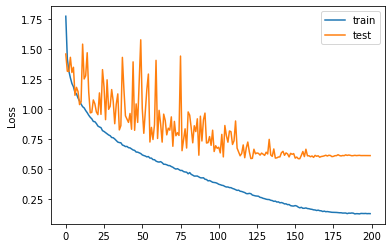

In [38]:
plt.plot(train_stat[:,1], label='train')
plt.plot(test_stat[:,1], label='test')
plt.ylabel("Loss")
plt.legend()
plt.savefig(f"./output/plots/{model_name}_loss.svg")
plt.show()

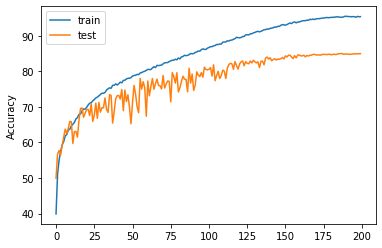

In [39]:
plt.plot(train_stat[:,2], label='train')
plt.plot(test_stat[:,2], label='test')
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(f"./output/plots/{model_name}_accs.svg")
plt.show()